# Importing Repositories

In [80]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import holidays
from scipy import stats
warnings.filterwarnings("ignore")
sns.set_theme(style="darkgrid")
plt.rcParams['figure.figsize']=(20,10)

In [81]:
def missing_zero_values_table(df):
        ''''Takes a pandas dataframe and returns a statistics table that explains the missing and 
        zero values'''
        zero_val = (df == 0.00).astype(int).sum(axis=0)
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mz_table = pd.concat([zero_val, mis_val, mis_val_percent], axis=1)
        mz_table = mz_table.rename(
        columns = {0 : 'Zero Values', 1 : 'Missing Values', 2 : '% of Total Values'})
        mz_table['Total Zero Missing Values'] = mz_table['Zero Values'] + mz_table['Missing Values']
        mz_table['% Total Zero Missing Values'] = 100 * mz_table['Total Zero Missing Values'] / len(df)
        mz_table['Data Type'] = df.dtypes
        mz_table = mz_table[
            mz_table.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("Our selected dataframe has " + str(df.shape[1]) + " columns and " + str(df.shape[0]) + " Rows.\n"      
            "There are " + str(mz_table.shape[0]) +
              " columns that have missing values.")
    
        return mz_table

# Importing data files

## Paths for files

In [82]:
path_price = r'C:\Users\2836589S\OneDrive - University of Glasgow\Data\DayAheadPrices_12.1.D'
path_totalload = r'C:\Users\2836589S\OneDrive - University of Glasgow\Data\DayAheadTotalLoadForecast'
path_windsolar = r'C:\Users\2836589S\OneDrive - University of Glasgow\Data\DayAheadGenerationForecastForWindAndSolar_14.1.D'

## Price Timeseries Importing

In [83]:

df_price = pd.read_csv(r'C:\Users\2836589S\OneDrive - University of Glasgow\Data\Data Frames\price_timeseries_outliers.csv', 
parse_dates=['DateTime'])


In [84]:
df_price = df_price[['DateTime', 'Year', 'Month','Week', 'Day', 'Hour', 'Price', 'Outlier']]
df_price

,DateTime,Year,Month,Week,Day,Hour,Price,Outlier
0,2015-01-01 00:00:00,2015,1,1,3,0,0.00,N
1,2015-01-01 01:00:00,2015,1,1,3,1,0.00,N
2,2015-01-01 02:00:00,2015,1,1,3,2,0.00,N
3,2015-01-01 03:00:00,2015,1,1,3,3,0.00,N
4,2015-01-01 04:00:00,2015,1,1,3,4,0.00,N
...,...,...,...,...,...,...,...,...
52529,2020-12-31 18:00:00,2020,12,53,3,18,71.30,N
52530,2020-12-31 19:00:00,2020,12,53,3,19,61.04,N
52531,2020-12-31 20:00:00,2020,12,53,3,20,60.39,N
52532,2020-12-31 21:00:00,2020,12,53,3,21,57.96,N


## Wind and Solar Timeseries Importing

In [85]:
f_windsolar = glob.glob(path_windsolar + "/*.csv")
dwindsolar = [pd.read_csv(f, sep='\t', parse_dates=['DateTime']) for f in f_windsolar]

df_windsolar = pd.concat(dwindsolar)
df_windsolar = df_windsolar[df_windsolar['AreaCode'] == '10YGB----------A']
df_windsolar = df_windsolar[['DateTime', 'ProductionType', 'AggregatedGenerationForecast']]
df_windsolar.sort_values(by='DateTime', ascending=True)
df_windsolar.reset_index(drop=True, inplace=True)

In [86]:
df_windsolar

,DateTime,ProductionType,AggregatedGenerationForecast
0,2014-12-30 00:00:00,Solar,0.00
1,2014-12-30 01:00:00,Solar,0.00
2,2014-12-30 02:00:00,Solar,0.00
3,2014-12-30 03:00:00,Solar,0.00
4,2014-12-30 04:00:00,Solar,0.00
...,...,...,...
509107,2021-06-14 19:00:00,Wind Offshore,1563.23
509108,2021-06-14 20:00:00,Wind Offshore,1590.47
509109,2021-06-14 21:00:00,Wind Offshore,1574.14
509110,2021-06-14 22:00:00,Wind Offshore,1450.72


### Splitting the WindSolar Dataset into 3 Datasets per Solar, Wind Offshore, Wind Onshore

In [87]:
df_windsolar['ProductionType'].unique()

array(['Solar', 'Wind Offshore', 'Wind Onshore'], dtype=object)

In [88]:
df_solar = df_windsolar[df_windsolar['ProductionType'] == 'Solar']
df_solar.sort_values(by='DateTime', ascending=True)
df_solar.reset_index(drop=True, inplace=True)
df_solar.rename(columns={'AggregatedGenerationForecast':'SolarGeneration'}, inplace=True)
df_solar = df_solar[['DateTime','SolarGeneration']]
df_solar

,DateTime,SolarGeneration
0,2014-12-30 00:00:00,0.0
1,2014-12-30 01:00:00,0.0
2,2014-12-30 02:00:00,0.0
3,2014-12-30 03:00:00,0.0
4,2014-12-30 04:00:00,0.0
...,...,...
169699,2021-06-14 19:00:00,227.0
169700,2021-06-14 20:00:00,11.5
169701,2021-06-14 21:00:00,0.0
169702,2021-06-14 22:00:00,0.0


In [89]:
# Taking of the outliers
q1 , q3 = np.percentile(df_solar['SolarGeneration'], [25,75])
iqr = q3 - q1
ul = q3 + 1.5*iqr
ll = q1 - 1.5*iqr
df_solar = df_solar[(df_solar['SolarGeneration'] > ll) | (df_solar['SolarGeneration'] < ul) ]

In [90]:
df_wind_off = df_windsolar[df_windsolar['ProductionType'] == 'Wind Offshore']
df_wind_off.sort_values(by='DateTime', ascending=True)
df_wind_off.reset_index(drop=True, inplace=True)
df_wind_off.rename(columns={'AggregatedGenerationForecast':'WindOffGeneration'}, inplace=True)
df_wind_off = df_wind_off[['DateTime', 'WindOffGeneration']]
df_wind_off

,DateTime,WindOffGeneration
0,2014-12-30 00:00:00,996.58
1,2014-12-30 01:00:00,1059.20
2,2014-12-30 02:00:00,1123.27
3,2014-12-30 03:00:00,1177.54
4,2014-12-30 04:00:00,1188.21
...,...,...
169699,2021-06-14 19:00:00,1563.23
169700,2021-06-14 20:00:00,1590.47
169701,2021-06-14 21:00:00,1574.14
169702,2021-06-14 22:00:00,1450.72


In [91]:
# Taking care of the outliers
q1 , q3 = np.percentile(df_wind_off['WindOffGeneration'], [25,75])
iqr = q3 - q1
ul = q3 + 1.5*iqr
ll = q1 - 1.5*iqr
df_wind_off = df_wind_off[(df_wind_off['WindOffGeneration'] > ll) | (df_wind_off['WindOffGeneration']) ]

In [92]:
df_wind_on = df_windsolar[df_windsolar['ProductionType'] == 'Wind Onshore']
df_wind_on.sort_values(by='DateTime', ascending=True)
df_wind_on.reset_index(drop=True, inplace=True)
df_wind_on.rename(columns={'AggregatedGenerationForecast':'WindOnGeneration'}, inplace=True)
df_wind_on = df_wind_on[['DateTime','WindOnGeneration']]
df_wind_on

,DateTime,WindOnGeneration
0,2014-12-30 00:00:00,2363.80
1,2014-12-30 01:00:00,2413.88
2,2014-12-30 02:00:00,2450.75
3,2014-12-30 03:00:00,2500.78
4,2014-12-30 04:00:00,2536.07
...,...,...
169699,2021-06-14 19:00:00,4896.71
169700,2021-06-14 20:00:00,3928.19
169701,2021-06-14 21:00:00,3277.03
169702,2021-06-14 22:00:00,2880.91


In [93]:
# Taking care of the outliers
q1 , q3 = np.percentile(df_wind_on['WindOnGeneration'], [25,75])
iqr = q3 - q1
ul = q3 + 1.5*iqr
ll = q1 - 1.5*iqr
df_wind_on = df_wind_on[(df_wind_on['WindOnGeneration'] > ll) | (df_wind_on['WindOnGeneration']) ]

## Total Load Timeseries Importing

In [94]:
f_totalload = glob.glob(path_totalload + "/*.csv")
dtotalload = [pd.read_csv(f, encoding='utf-16', sep='\t', parse_dates=['DateTime']) for f in f_totalload]

df_totalload = pd.concat(dtotalload)
df_totalload = df_totalload[df_totalload['AreaCode'] == '10YGB----------A']
df_totalload = df_totalload[['DateTime', 'TotalLoadValue']]
df_totalload.reset_index(drop=True, inplace=True)


In [95]:
df_totalload.sort_values(by=['DateTime'], ascending=True)
df_totalload.reset_index(drop=True, inplace=True)
df_totalload

,DateTime,TotalLoadValue
0,2014-12-29 00:00:00,28798.0
1,2014-12-29 02:00:00,29534.0
2,2014-12-29 00:30:00,29961.0
3,2014-12-29 02:30:00,29627.0
4,2014-12-29 04:30:00,26717.0
...,...,...
202693,2020-09-30 14:30:00,34726.0
202694,2020-09-30 16:30:00,36430.0
202695,2020-09-30 18:30:00,36366.0
202696,2020-09-30 20:30:00,29449.0


# Merging Datasets

In [96]:
df_price = df_price[df_price['Outlier'] == 'N']
df_merged = pd.merge(df_price, df_solar, how='left', on='DateTime')
df_merged = pd.merge(df_merged, df_wind_off, how='left', on='DateTime')
df_merged = pd.merge(df_merged, df_wind_on, how='left', on='DateTime')

In [97]:
df_merged.drop_duplicates(subset=['DateTime'], keep='first', inplace=True)

In [98]:
df_model = pd.DataFrame()
df_model = df_merged[['Price','Year', 'Month', 'Day', 'Hour', 'SolarGeneration', 'WindOffGeneration',
'WindOnGeneration']]
df_model.set_index(df_merged['DateTime'], inplace=True)
df_model

,Price,Year,Month,Day,Hour,SolarGeneration,WindOffGeneration,WindOnGeneration
DateTime,,,,,,,,
2015-01-01 00:00:00,0.00,2015,1,3,0,0.0,2987.05,4013.58
2015-01-01 01:00:00,0.00,2015,1,3,1,0.0,2926.71,4074.53
2015-01-01 02:00:00,0.00,2015,1,3,2,0.0,2867.00,4157.48
2015-01-01 03:00:00,0.00,2015,1,3,3,0.0,2808.72,4229.50
2015-01-01 04:00:00,0.00,2015,1,3,4,0.0,2769.59,4133.56
...,...,...,...,...,...,...,...,...
2020-12-31 18:00:00,71.30,2020,12,3,18,0.0,2644.97,3028.41
2020-12-31 19:00:00,61.04,2020,12,3,19,0.0,2707.55,3046.72
2020-12-31 20:00:00,60.39,2020,12,3,20,0.0,2695.01,3053.60


## Transforming Solar, Wind Onshore and Wind Offshore Generation values

In [99]:
df_model['SolarGeneration'] = df_model['SolarGeneration'].transform('sqrt')
df_model['WindOffGeneration'] = df_model['WindOffGeneration'].transform('sqrt')
df_model['WindOnGeneration'] = df_model['WindOnGeneration'].transform('sqrt')

## Creating Season column

In [100]:
# seasons = []

# for i in range(len(df_model)):
#     if df_model.iloc[i, 2] in [9,10,11]:
#         seasons.append('autumn')
#     elif df_model.iloc[i, 2] in [12,1,2]:
#         seasons.append('winter')
#     elif df_model.iloc[i, 2] in [3,4,5]:
#         seasons.append('spring')
#     elif df_model.iloc[i, 2] in [6,7,8]:
#         seasons.append('summer')



In [101]:
# df_model['Seasons'] = seasons
# df_model = pd.get_dummies(columns=['Seasons'], data=df_model)
# df_model

# Re-forming our dataset

## Creating single-hour data blocks

In [102]:
df_model.dropna(inplace=True)

In [103]:
hours = df_model['Hour'].unique().tolist()
df_hour ={hour: pd.DataFrame() for hour in hours}
for i in range(len(hours)):
    df_hour[i] = df_model[df_model['Hour'] == i]
    df_hour[i] = df_hour[i][(np.abs(stats.zscore(df_hour[i]['Price']))<3)]


## Creating lags (6 month lags)

In [104]:
lags = list(range(1,90))

In [105]:
def lag_col(df, variable, lags):
    for lag in lags:
        df[str(variable) + '_' + str(lag)] = df[variable].shift(lag)
    return df

In [106]:
for i in range(len(hours)):
        lag_col(df_hour[i], 'Price', lags)
        lag_col(df_hour[i], 'SolarGeneration', lags)
        lag_col(df_hour[i], 'WindOffGeneration', lags)
        lag_col(df_hour[i], 'WindOnGeneration', lags)

In [107]:
df_hour[0]

,Price,Year,Month,Day,Hour,SolarGeneration,WindOffGeneration,WindOnGeneration,Price_1,Price_2,...,WindOnGeneration_80,WindOnGeneration_81,WindOnGeneration_82,WindOnGeneration_83,WindOnGeneration_84,WindOnGeneration_85,WindOnGeneration_86,WindOnGeneration_87,WindOnGeneration_88,WindOnGeneration_89
DateTime,,,,,,,,,,,,,,,,,,,,,
2015-01-02,27.94,2015,1,4,0,0.0,59.645788,73.214411,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-03,35.94,2015,1,5,0,0.0,53.118358,65.199233,27.94,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-04,40.01,2015,1,6,0,0.0,22.629406,31.585440,35.94,27.94,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-05,36.55,2015,1,0,0,0.0,33.416762,48.506288,40.01,35.94,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-06,36.02,2015,1,1,0,0.0,42.693442,58.826100,36.55,40.01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-27,4.70,2020,12,6,0,0.0,98.853933,88.450438,29.98,59.90,...,34.679677,44.248277,64.931348,36.439539,34.901719,51.837535,70.416191,48.663025,32.306656,57.529384
2020-12-28,56.00,2020,12,0,0,0.0,61.641950,47.702096,4.70,29.98,...,41.381759,34.679677,44.248277,64.931348,36.439539,34.901719,51.837535,70.416191,48.663025,32.306656
2020-12-29,64.95,2020,12,1,0,0.0,34.614737,40.164039,56.00,4.70,...,68.405555,41.381759,34.679677,44.248277,64.931348,36.439539,34.901719,51.837535,70.416191,48.663025


In [108]:
range(len(hours))

range(0, 24)

In [109]:
for i in range(len(hours)):
    df_hour[i].drop(columns=['Year','Day','Month','Hour'], inplace=True)
    df_hour[i].dropna(inplace=True)

# Lasso Model

## Dataset Split

In [110]:
X = {hour: pd.DataFrame() for hour in hours}
y = {hour: pd.DataFrame() for hour in hours}

In [111]:
for hour in range(len(hours)):
    X[hour] = df_hour[hour].drop(columns='Price')
    y[hour] = df_hour[hour].Price

## Lasso Regressor and TimeSeriesSplit

In [112]:
# Create empty dataframes with hour as index in order to fill the trained models, and train them accordingly
from sklearn.linear_model import LassoCV
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
model = {hour: pd.DataFrame() for hour in hours}

rsquared = []
alphaval = []
model_name = []
intercept = []


for hour in hours:
    model[hour] = LassoCV(cv=tscv, random_state=0).fit(X[hour],y[hour])
    rsquared.append(model[hour].score(X[hour], y[hour]))
    alphaval.append(model[hour].alpha_)
    intercept.append(model[hour].intercept_)
    model_name.append('model[' + str(hour) + ']')

In [113]:
model_results = pd.DataFrame(columns=['Model', 'Rsquared Value', 'Alpha Value', 'Intercept'])
model_results['Model'] = model_name
model_results['Rsquared Value'] = rsquared
model_results['Alpha Value'] = alphaval
model_results['Intercept'] = intercept
model_results

,Model,Rsquared Value,Alpha Value,Intercept
0,model[0],0.812765,0.560322,1.793152
1,model[1],0.826662,0.549445,1.544092
2,model[2],0.837023,0.509729,1.423248
3,model[3],0.831284,0.698407,1.602607
4,model[4],0.808212,0.929025,1.360478
5,model[5],0.792121,1.308787,1.148225
6,model[6],0.787852,2.327573,1.335067
7,model[7],0.715467,3.571590,3.327805
8,model[8],0.715558,4.708520,5.674498
9,model[9],0.780045,1.938015,3.225698


In [114]:
# model_results.to_excel(r'C:\Users\2836589S\OneDrive - University of Glasgow\Data\Lasso_Results.xlsx', index=False)

In [115]:
df_coef = {hour: pd.DataFrame() for hour in hours}
for hour in hours:
    df_coef[hour].index = X[hour].transpose().index
    df_coef[hour]['Coefficients'] = model[hour].coef_.transpose()
    df_coef[hour].sort_values(by='Coefficients', ascending=False, inplace=True)
    df_coef[hour]


In [116]:
a = df_coef[3].head(10)

Text(0.5, 0, 'Coefficients')

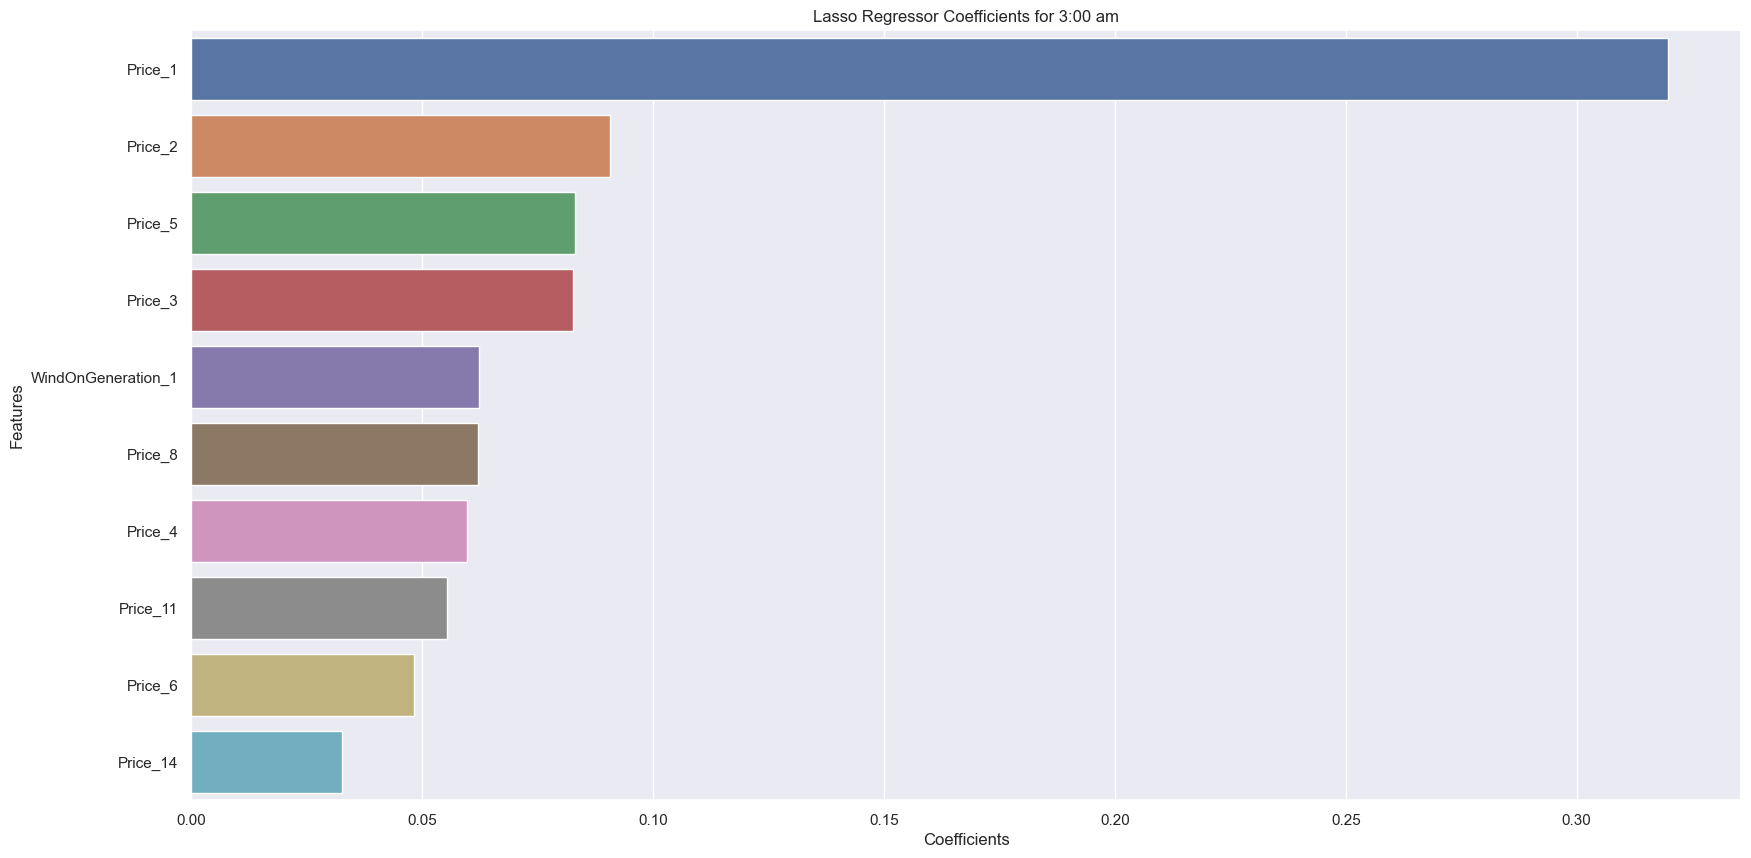

In [117]:
sns.barplot(x=a['Coefficients'],y=a.index )
plt.title('Lasso Regressor Coefficients for 3:00 am')
plt.ylabel('Features')
plt.xlabel('Coefficients')

In [118]:
lasso_1 = pd.DataFrame(columns=['Actual Value', 'Predicted Value', 'Residual', 'Squared Residuals'])
lasso_1['Actual Value'] = y[9]
lasso_1['Predicted Value'] = model[9].predict(X[9])
lasso_1['Residual'] = lasso_1['Actual Value'] - lasso_1['Predicted Value']
lasso_1['Squared Residuals'] = lasso_1['Residual'].mul(lasso_1['Residual'])

In [119]:
lasso = {hour: pd.DataFrame() for hour in hours}

for hour in hours:
    lasso[hour] = pd.DataFrame(columns=['Actual Value', 'Predicted Value', 'Residual', 'Squared Residuals'])
    lasso[hour]['Actual Value'] = y[hour]
    lasso[hour]['Predicted Value'] = model[hour].predict(X[hour])
    lasso[hour]['Residual'] = lasso[hour]['Actual Value'] - lasso[hour]['Predicted Value']
    lasso[hour]['Squared Residuals'] = lasso[hour]['Residual'].mul(lasso[hour]['Residual'])


In [120]:
lasso[15]

,Actual Value,Predicted Value,Residual,Squared Residuals
DateTime,,,,
2015-04-03 15:00:00,50.07,42.647998,7.422002,55.086117
2015-04-04 15:00:00,40.90,43.971696,-3.071696,9.435315
2015-04-05 15:00:00,41.58,42.648614,-1.068614,1.141936
2015-04-06 15:00:00,40.00,41.102588,-1.102588,1.215700
2015-04-07 15:00:00,41.98,44.121646,-2.141646,4.586648
...,...,...,...,...
2020-12-27 15:00:00,50.70,45.430544,5.269456,27.767171
2020-12-28 15:00:00,48.19,55.123173,-6.933173,48.068890
2020-12-29 15:00:00,53.76,49.951551,3.808449,14.504286


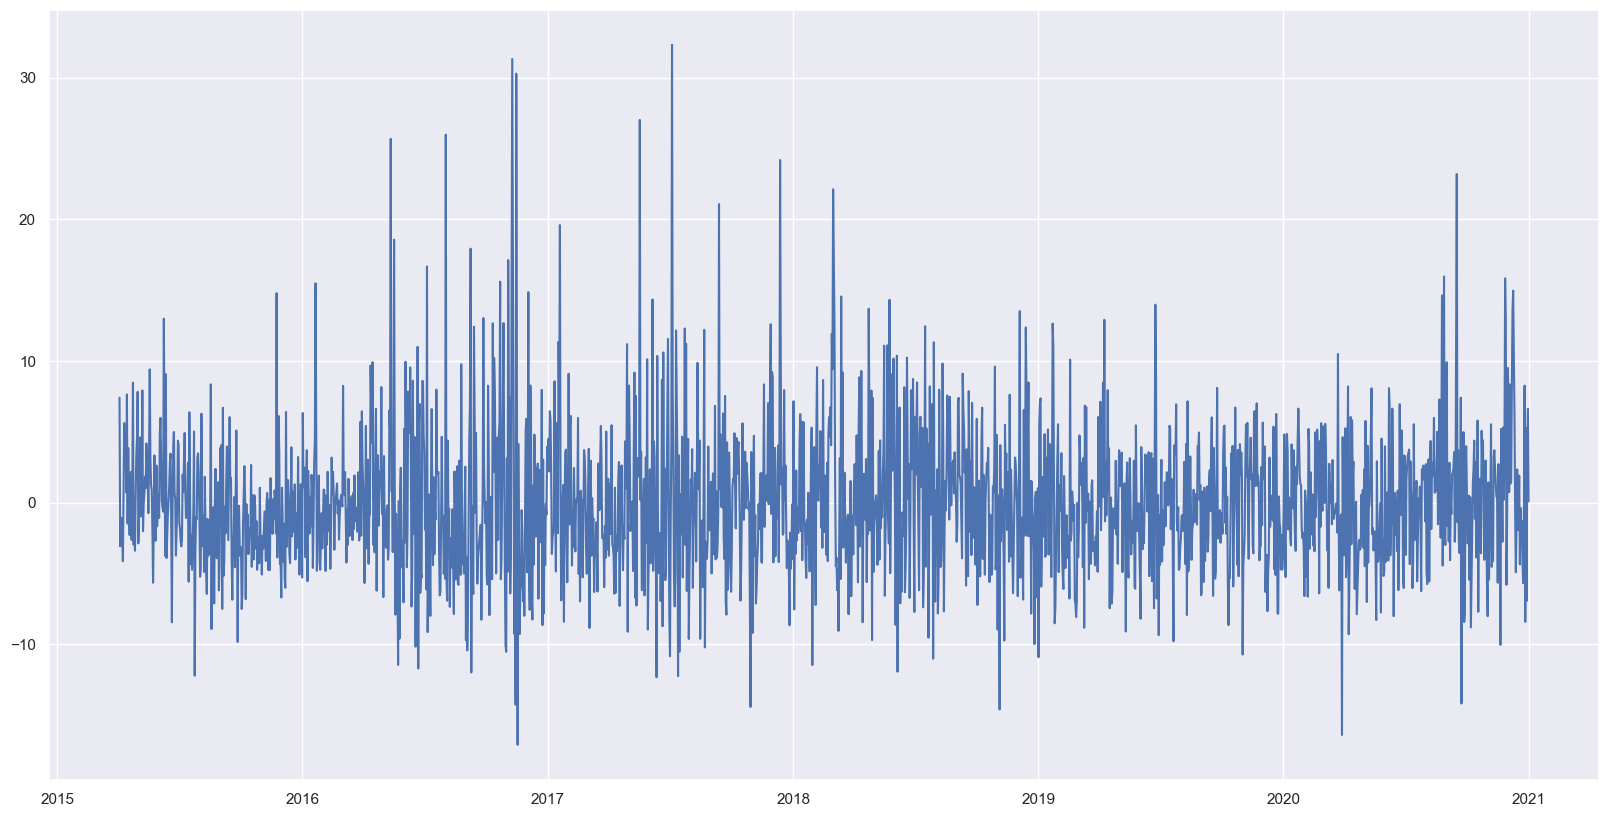

In [121]:
plt.plot(lasso[15]['Residual'])

## Garch Model

In [170]:
from arch import arch_model

arch_lasso_exp = arch_model(lasso[20]['Residual'], vol='GARCH', p=1,q=1, dist='t', mean='Constant')
arch_lasso_exp = arch_lasso_exp.fit()
arch_lasso_exp.summary()

Iteration:      1,   Func. Count:      7,   Neg. LLF: 182036.45345752488
Iteration:      2,   Func. Count:     16,   Neg. LLF: 13964.869880904615
Iteration:      3,   Func. Count:     26,   Neg. LLF: 6755.760206050119
Iteration:      4,   Func. Count:     35,   Neg. LLF: 5854.55051622325
Iteration:      5,   Func. Count:     42,   Neg. LLF: 8207.35329709325
Iteration:      6,   Func. Count:     49,   Neg. LLF: 5849.184215378093
Iteration:      7,   Func. Count:     56,   Neg. LLF: 5847.865007901221
Iteration:      8,   Func. Count:     62,   Neg. LLF: 5847.8163027200335
Iteration:      9,   Func. Count:     68,   Neg. LLF: 5847.800323167118
Iteration:     10,   Func. Count:     74,   Neg. LLF: 5847.797242575123
Iteration:     11,   Func. Count:     80,   Neg. LLF: 5847.7972169464265
Iteration:     12,   Func. Count:     85,   Neg. LLF: 5847.797216946421
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5847.7972169464265
            Iterations: 1

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Constant Mean - GARCH Model Results                         
====================================================================================
Dep. Variable:                     Residual   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -5847.80
Distribution:      Standardized Student's t   AIC:                           11705.6
Method:                  Maximum Likelihood   BIC:                           11733.7
                                              No. Observations:                 2048
Date:                      Sat, Jan 21 2023   Df Residuals:                     2047
Time:                              11:56:13   Df Model:                            1
                                 Mean Model                                
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu            -0.1924  9.385e-02     -2.050  4.033e-02 [ -0.376,-8.481e-03]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.2540      0.121      2.100  3.573e-02   [1.694e-02,  0.491]
alpha[1]       0.0549  1.235e-02      4.446  8.760e-06 [3.069e-02,7.908e-02]
beta[1]        0.9333  1.589e-02     58.718      0.000     [  0.902,  0.964]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             9.1711      1.662      5.518  3.432e-08 [  5.913, 12.429]
========================================================================

Covariance estimator: robust
"""

Text(0.5, 1.0, 'Volatility for 8:00 am')

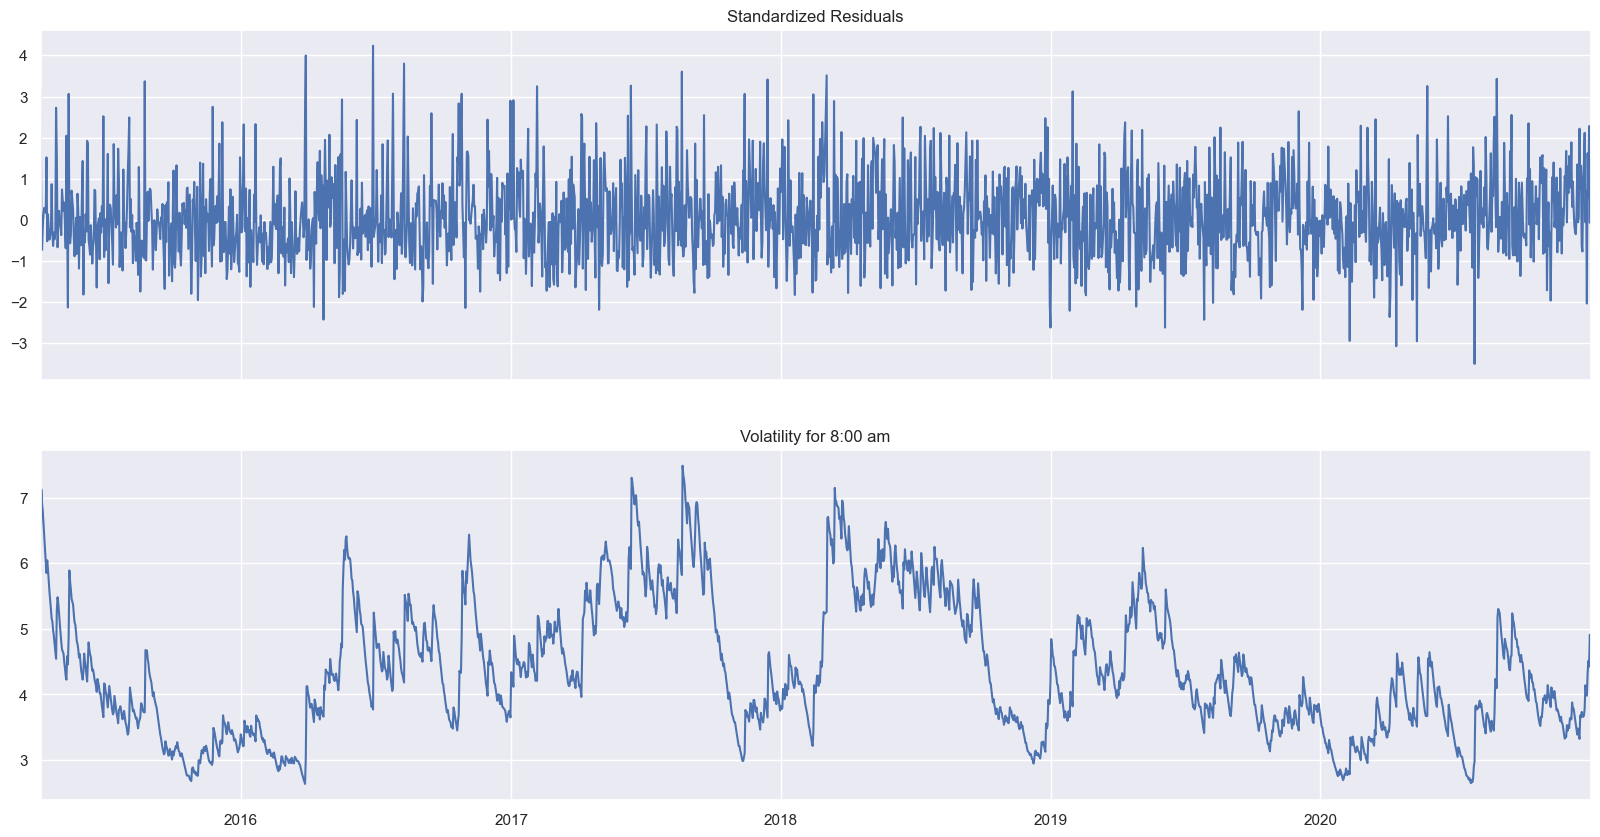

In [171]:
arch_lasso_exp.plot();
plt.title('Volatility for 8:00 am')


Text(0.5, 1.0, 'Distribution of Standardized Residuals for GARCH(1,1) - 8:00 am')

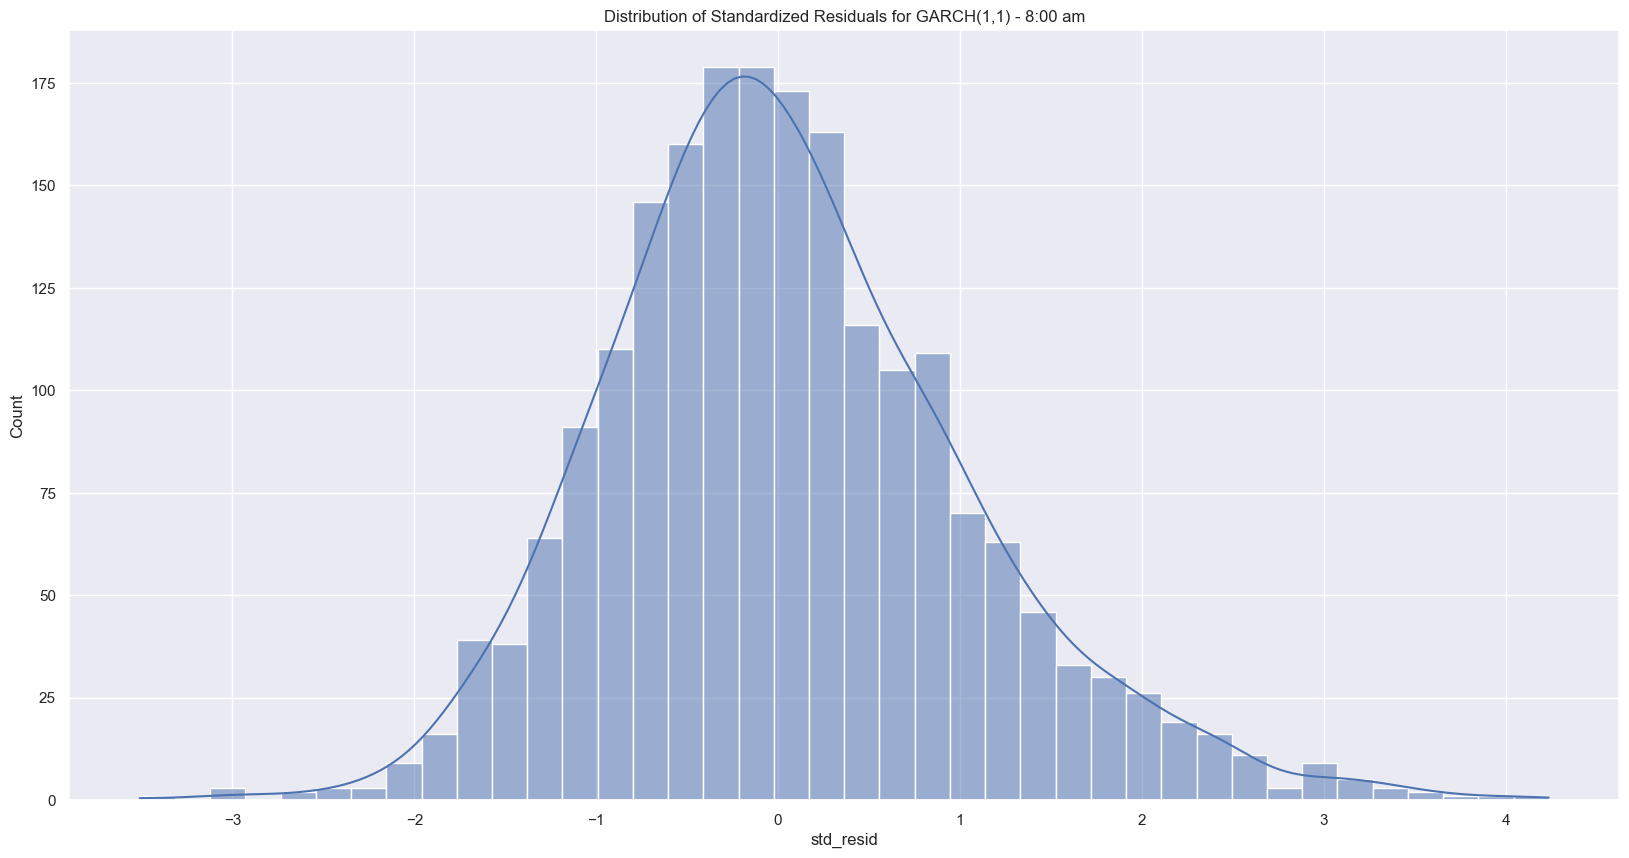

In [172]:
sns.histplot(arch_lasso_exp.std_resid, kde=True)
plt.title('Distribution of Standardized Residuals for GARCH(1,1) - 8:00 am')

Text(0.5, 1.0, 'QQplot for Standardized Residuals - GARCH(1,1) 8:00 am')

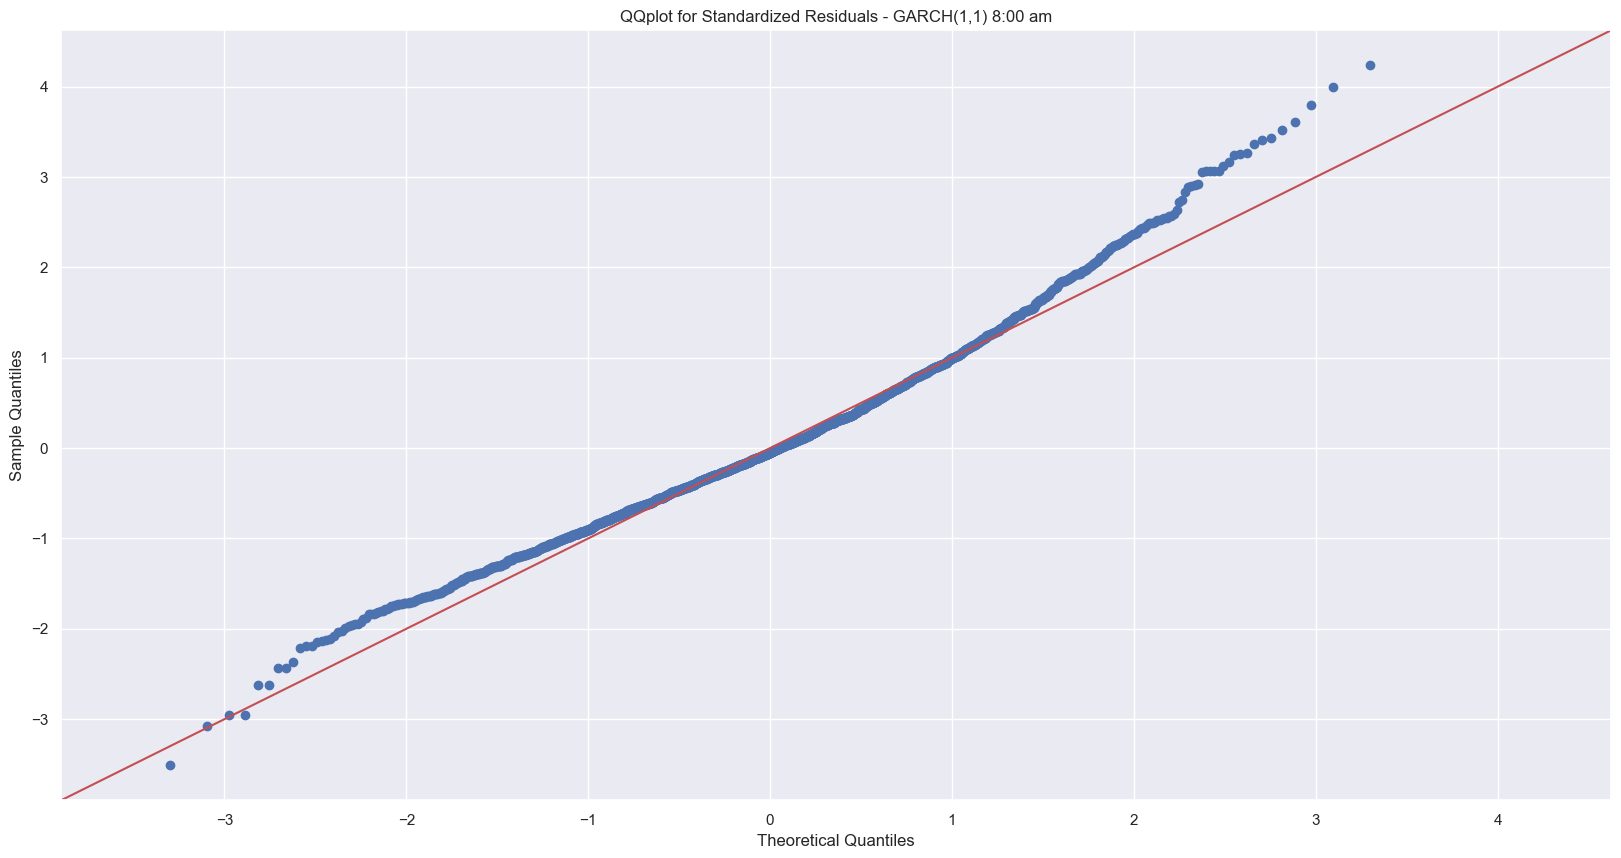

In [173]:
import statsmodels.api as sm
from scipy.stats import norm
import pylab

x = arch_lasso_exp.std_resid
sm.qqplot(x, line='45')

plt.title('QQplot for Standardized Residuals - GARCH(1,1) 8:00 am')

In [174]:
%%capture
from scipy import stats

model = []
pvalue = []
meanval = []
length_resid = []
Q1 = []
Q3 = []

for hour in hours:
    arch_lasso = arch_model(lasso[hour]['Residual'], vol='GARCH', p=1,q=1, dist='t', mean='Zero')
    arch_lasso = arch_lasso.fit()
    x = arch_lasso.std_resid
    stat_test = stats.kstest(x, "norm", alternative='less')
    q1 = np.quantile(x, .25)
    q3 = np.quantile(x, .75)
    model.append('Garch_Lasso['+str(hour)+']')
    pvalue.append(stat_test.pvalue)
    meanval.append(np.mean(x))
    length_resid.append(len(x))
    Q1.append(q1)
    Q3.append(q3)



In [175]:
df_arch_results = pd.DataFrame(columns=['Model', 'Pvalues for Normality', 'Mean', 'Sample Length', 'Q1', 'Q3'])
df_arch_results['Model'] = model
df_arch_results['Pvalues for Normality'] = pvalue
df_arch_results['Mean'] = meanval
df_arch_results['Sample Length'] = length_resid
df_arch_results['Q1'] = Q1
df_arch_results['Q3'] = Q3
df_arch_results

,Model,Pvalues for Normality,Mean,Sample Length,Q1,Q3
0,Garch_Lasso[0],4.220814e-05,0.006395,2059,-0.585260,0.535544
1,Garch_Lasso[1],1.017923e-04,-0.002276,2041,-0.552150,0.543161
2,Garch_Lasso[2],6.731977e-06,-0.013188,2006,-0.520383,0.553335
3,Garch_Lasso[3],7.810655e-07,-0.009638,1963,-0.519044,0.588508
4,Garch_Lasso[4],3.487556e-06,-0.010259,1968,-0.508923,0.586497
5,Garch_Lasso[5],5.656163e-05,-0.012522,2049,-0.551284,0.544043
6,Garch_Lasso[6],1.476508e-02,-0.012326,2065,-0.586011,0.547744
7,Garch_Lasso[7],5.623237e-02,-0.008775,2028,-0.639559,0.577820
8,Garch_Lasso[8],4.580207e-01,-0.010475,2015,-0.645023,0.637185
9,Garch_Lasso[9],4.018724e-01,-0.004200,2049,-0.684603,0.634834


In [176]:
from statsmodels.tsa.arima_process import ArmaProcess

ar = np.array([1, -0.9])
ma = np.array([1])

sim_step = []
mean = []
sd = []

for j in range(len(df_arch_results)):
    for i in range(0,1000):
        ar_factor = ArmaProcess(ar,ma)
        sim_data = ar_factor.generate_sample(nsample=df_arch_results.loc[j][3])
    sim_step.append('sim_arch_lasso_sample_' + str(j))
    mean.append(np.mean(sim_data))
    sd.append(np.std(sim_data))
        

df_simulation = pd.DataFrame(columns=['Simulation', 'Mean', 'SD'])
df_simulation['Simulation'] = sim_step
df_simulation['Mean'] = mean
df_simulation['SD'] = sd
df_simulation
df_compare = pd.concat([df_arch_results, df_simulation], axis="columns")

check = []

for i in range(len(df_compare)):
    if df_compare.iloc[i][7] >= df_compare.iloc[i][4] and df_compare.iloc[i][7] <= df_compare.iloc[i][5]:
        check.append('OK')
    else:
        check.append('NO')

df_compare['Test'] = check

In [177]:
df_compare

,Model,Pvalues for Normality,Mean,Sample Length,Q1,Q3,Simulation,Mean,SD,Test
0,Garch_Lasso[0],4.220814e-05,0.006395,2059,-0.585260,0.535544,sim_arch_lasso_sample_0,-0.304873,2.170472,OK
1,Garch_Lasso[1],1.017923e-04,-0.002276,2041,-0.552150,0.543161,sim_arch_lasso_sample_1,-0.156523,2.129469,OK
2,Garch_Lasso[2],6.731977e-06,-0.013188,2006,-0.520383,0.553335,sim_arch_lasso_sample_2,-0.024115,2.269021,OK
3,Garch_Lasso[3],7.810655e-07,-0.009638,1963,-0.519044,0.588508,sim_arch_lasso_sample_3,-0.067271,2.504223,OK
4,Garch_Lasso[4],3.487556e-06,-0.010259,1968,-0.508923,0.586497,sim_arch_lasso_sample_4,-0.095998,2.163189,OK
5,Garch_Lasso[5],5.656163e-05,-0.012522,2049,-0.551284,0.544043,sim_arch_lasso_sample_5,-0.000280,2.220338,OK
6,Garch_Lasso[6],1.476508e-02,-0.012326,2065,-0.586011,0.547744,sim_arch_lasso_sample_6,-0.032529,2.219634,OK
7,Garch_Lasso[7],5.623237e-02,-0.008775,2028,-0.639559,0.577820,sim_arch_lasso_sample_7,-0.216330,2.425430,OK
8,Garch_Lasso[8],4.580207e-01,-0.010475,2015,-0.645023,0.637185,sim_arch_lasso_sample_8,0.075627,2.133205,OK
9,Garch_Lasso[9],4.018724e-01,-0.004200,2049,-0.684603,0.634834,sim_arch_lasso_sample_9,-0.199480,2.354939,OK


In [178]:
# df_compare.to_excel(r'C:\Users\2836589S\OneDrive - University of Glasgow\Data\garch_lasso_simulation.xlsx', index=False)

In [179]:
# lasso[8].to_excel(r'C:\Users\2836589S\OneDrive - University of Glasgow\Data\lasso8.xlsx', index=True)

In [180]:
# arch_lasso_exp.std_resid.to_csv(r'C:\Users\2836589S\OneDrive - University of Glasgow\Data\resid2016.csv')

In [181]:
# df_hour[8].to_excel(r'C:\Users\2836589S\OneDrive - University of Glasgow\Data\df_h_8.xlsx')